# .STL Formatındaki Dosyayı Point Clouda Çevirme

In [42]:
import numpy as np
import open3d as o3d
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
%matplotlib inline 

mesh = o3d.io.read_triangle_mesh("datasets/data/points3.stl")
pointcloud = mesh.sample_points_uniformly(10000)

# you can plot and check
#o3d.visualization.draw_geometries([mesh])
o3d.visualization.draw_geometries([pointcloud])

# Point Cloud'un Görselleştirilmesi

z ekseni data frame'de normal ancak matplotlib'de basık nedenini henüz anlamadım.

               0           1          2
0     142.000000   92.064368   0.077126
1     142.000000  -43.744403   0.210691
2     142.000000  -47.896583   0.353129
3     142.000000  -90.581940   0.102962
4     142.000000  107.803720   0.536846
...          ...         ...        ...
9995   48.094523   -2.785526  14.812183
9996   47.285037   -8.253265  14.350440
9997   45.305440   -3.196446  11.851773
9998   41.535357   -4.400353  12.684305
9999   44.736590   -8.469351  17.282442

[10000 rows x 3 columns]


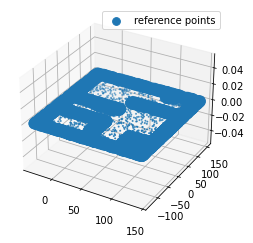

In [49]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
pd.options.display.width = None
pd.options.display.max_columns = None
pd.set_option('display.max_rows', 3000)
pd.set_option('display.max_columns', 3000)
df = pd.DataFrame(np.asarray(pointcloud.points))
print(df)
df = df.set_axis(['x', 'y', 'z'], axis=1, inplace=False)
plt.scatter(df["x"], df["y"],df["z"],label='reference points')
plt.legend()
plt.show()

# Test Verisini Alma

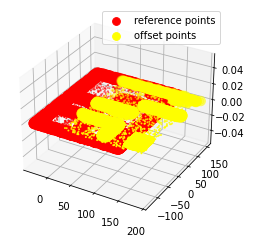

In [50]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
plt.scatter(df.x, df.y,df.z, color='red',label='reference points')
df1 = pd.DataFrame()
df1['x'] = df.x[1000:5000]+50
df1['y'] = df.y[1000:5000]
df1['z'] = df.z[1000:5000]
plt.scatter(df1.x, df1.y,df1.z, color='yellow',label='offset points')
plt.legend()
plt.show()

# ICP Fonksiyonları

Burda kullandığım kodları
https://github.com/dakshaau/ICP/blob/master/icp.py 
adresinden aldım.

Icp (Iterative Closest Point) fonksiyonunda değişiklik yapıp ihtiyacıma göre düzenledim.

In [36]:
def best_fit_transform(A, B):
    '''
    Calculates the least-squares best-fit transform between corresponding 3D points A->B
    Input:
      A: Nx3 numpy array of corresponding 3D points
      B: Nx3 numpy array of corresponding 3D points
    Returns:
      T: 4x4 homogeneous transformation matrix
      R: 3x3 rotation matrix
      t: 3x1 column vector
    '''

    assert len(A) == len(B)

    # translate points to their centroids
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    AA = A - centroid_A
    BB = B - centroid_B

    # rotation matrix
    H = np.dot(AA.T, BB)
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    # special reflection case
    if np.linalg.det(R) < 0:
       Vt[2,:] *= -1
       R = np.dot(Vt.T, U.T)

    # translation
    t = centroid_B.T - np.dot(R,centroid_A.T)

    # homogeneous transformation
    T = np.identity(4)
    T[0:3, 0:3] = R
    T[0:3, 3] = t

    return T, R, t


In [37]:
def nearest_neighbor(src, dst):
    '''
    Find the nearest (Euclidean) neighbor in dst for each point in src
    Input:
        src: Nx3 array of points
        dst: Nx3 array of points
    Output:
        distances: Euclidean distances of the nearest neighbor
        indices: dst indices of the nearest neighbor
    '''

    all_dists = cdist(src, dst, 'euclidean')
    indices = all_dists.argmin(axis=1)
    distances = all_dists[np.arange(all_dists.shape[0]), indices]
    return distances, indices


In [38]:
def icp(A, B, init_pose=None, max_iterations=20, tolerance=0.0008):
    '''
    The Iterative Closest Point method
    Input:
        A: Nx3 numpy array of source 3D points
        B: Nx3 numpy array of destination 3D point
        init_pose: 4x4 homogeneous transformation
        max_iterations: exit algorithm after max_iterations
        tolerance: convergence criteria
    Output:
        T: final homogeneous transformation
        distances: Euclidean distances (errors) of the nearest neighbor
    '''

    # make points homogeneous, copy them so as to maintain the originals
    src = np.ones((4,A.shape[0]))
    dst = np.ones((4,B.shape[0]))
    src[0:3,:] = np.copy(A.T)
    dst[0:3,:] = np.copy(B.T)

    # apply the initial pose estimation
    if init_pose is not None:
        src = np.dot(init_pose, src)

    prev_error = 0

    for i in range(max_iterations):
        # find the nearest neighbours between the current source and destination points
        distances, indices = nearest_neighbor(src[0:3,:].T, dst[0:3,:].T)

        # compute the transformation between the current source and nearest destination points
        T,_,_ = best_fit_transform(src[0:3,:].T, dst[0:3,indices].T)

        # update the current source
        src = np.dot(T, src)

        # check error
        mean_error = np.sum(distances) / distances.size
        print(f"error:{abs(prev_error - mean_error)}")
        if abs(prev_error-mean_error) < tolerance:
            break
        prev_error = mean_error

    # calculate final transformation
    T,_,_ = best_fit_transform(A, src[0:3,:].T)
    
    """
    Bu kısımdan sonrasını düzenledim
    
    """
    # https://math.stackexchange.com/questions/237369/given-this-transformation-matrix-how-do-i-decompose-it-into-translation-rotati
    
    translation=[T[0][3],T[1][3],T[2][3]]
    sx=[T[0][0],T[1][0],T[2][0]]
    sy=[T[0][1],T[1][1],T[2][1]]
    sz=[T[0][2],T[1][2],T[2][2]]
    s=[sx,sy,sz]
    rotation=[[T[0][0]/sx,T[0][1]/sx,T[0][2]/sz,0],[T[1][0]/sx,T[1][1]/sx,T[1][2]/sz,0],[T[2][0]/sx,T[2][1]/sx,T[2][2]/sz,0],[0,0,0,1]]
    return T, distances,translation,rotation,s

In [51]:
transformation_history, aligned_points,translation,rotation,s = icp(df.to_numpy(), df1.to_numpy(),max_iterations=500)
output=pd.DataFrame()
print(translation[0],translation[1],translation[2])

error:26.808843489067275
error:4.776121376841754
error:2.5189535196237536
error:1.6719310534373726
error:0.9601001644285709
error:0.45477183719165026
error:0.18184122110776002
error:0.06336649013957896
error:0.027548191968406854
error:0.010099411563164296
error:0.010637902762606899
error:0.004483880984029298
error:0.007803114440260828
error:0.006229557863040469
error:0.006088193511263995
error:0.003250833530607622
error:0.002498207063787561
error:0.0004946146108792959
45.161070281984124 14.478812871581514 -5.078784915465263


In [52]:
output['x']=df1.x-translation[0]
output['y']=df1.y-translation[1]
output['z']=df1.z-translation[2]
concat=pd.DataFrame()
concat= pd.concat([df1.x,output.x,df['x'][1000:5000]], axis='columns')
concat=concat.set_axis(['+50 x offset [df1]', 'calculated x [output]','real values'], axis=1, inplace=False)
print(concat)

      +50 x offset [df1]  calculated x [output]  real values
1000           55.614248              10.453178     5.614248
1001           31.705631             -13.455440   -18.294369
1002           28.064658             -17.096412   -21.935342
1003           47.869017               2.707947    -2.130983
1004           25.729412             -19.431658   -24.270588
...                  ...                    ...          ...
4995          181.094875             135.933805   131.094875
4996          159.323826             114.162756   109.323826
4997          163.469497             118.308427   113.469497
4998          116.825729              71.664659    66.825729
4999          150.987403             105.826333   100.987403

[4000 rows x 3 columns]


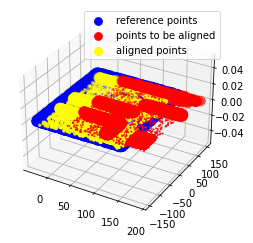

In [53]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
plt.scatter(df.x,df.y,df.z,color='blue',label='reference points')
plt.scatter(df1.x,df1.y,df1.z,color='red',label='points to be aligned')
plt.scatter(output.x,output.y,output.z,color='yellow',label='aligned points')
plt.legend()
plt.show()